In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import flair
from flair.datasets import CONLL_03, WNUT_17, ONTONOTES, NER_ENGLISH_MOVIE_SIMPLE, NER_ENGLISH_RESTAURANT
from collections import defaultdict, deque
from pathlib import Path

sns.set_theme(style="whitegrid", palette="Set2")
sns.set_context("paper")
plt.rcParams['savefig.dpi'] = 300

In [8]:
# dataset = CONLL_03()
# dataset_name = "CoNLL 2003"

# dataset = WNUT_17()
# dataset_name = "WNUT 2017"

# dataset = ONTONOTES()
# dataset_name = "ONTONOTES"

# dataset = NER_ENGLISH_MOVIE_SIMPLE()
# dataset_name = "MIT_ENGLISH_MOVIE"

dataset = NER_ENGLISH_RESTAURANT()
dataset_name = "MIT ENGLISH RESTAURANT"

# dataset_name = dataset_name.title()

2024-09-16 14:19:57,478 Reading data from /Users/cezary/.flair/datasets/ner_english_restaurant
2024-09-16 14:19:57,479 Train: /Users/cezary/.flair/datasets/ner_english_restaurant/train.txt
2024-09-16 14:19:57,480 Dev: None
2024-09-16 14:19:57,481 Test: /Users/cezary/.flair/datasets/ner_english_restaurant/test.txt
2024-09-16 14:19:57,932 No dev split found. Using 10% (i.e. 766 samples) of the train split as dev data


In [9]:
full_dataset = torch.utils.data.dataset.ConcatDataset([dataset.train, dataset.dev, dataset.test])

label_counts = defaultdict(int)

for sentence in full_dataset:
    sentence_dict = sentence.to_dict(tag_type="ner")

    token_count = len(sentence_dict["tokens"])
    entity_count = len(sentence_dict["entities"])

    label_counts["O"] += token_count - entity_count

    for entity in sentence_dict["entities"]:
        max_confidence_label = max(entity["labels"], key=lambda x: x["confidence"])
        label_counts[max_confidence_label["value"]] += 1

label_counts

defaultdict(int,
            {'O': 66267,
             'Rating': 1271,
             'Amenity': 3074,
             'Location': 4629,
             'Restaurant_Name': 2303,
             'Price': 901,
             'Hours': 1202,
             'Dish': 1763,
             'Cuisine': 3371})

In [10]:
df = pd.DataFrame(label_counts.items(), columns=["label", "label_count"])
df["label"] = df["label"].str.upper()
ordering = np.roll(np.arange(len(df)), -1)
df = df.reindex(ordering).reset_index(drop=True)
# lc_df.loc[5] = ["Total", df["label_count"].sum()]
df

,label,label_count
0,RATING,1271
1,AMENITY,3074
2,LOCATION,4629
3,RESTAURANT_NAME,2303
4,PRICE,901
5,HOURS,1202
6,DISH,1763
7,CUISINE,3371
8,O,66267


In [11]:
ne_only_df = df.drop(len(df)-1).reset_index(drop=True)
ne_only_df

,label,label_count
0,RATING,1271
1,AMENITY,3074
2,LOCATION,4629
3,RESTAURANT_NAME,2303
4,PRICE,901
5,HOURS,1202
6,DISH,1763
7,CUISINE,3371


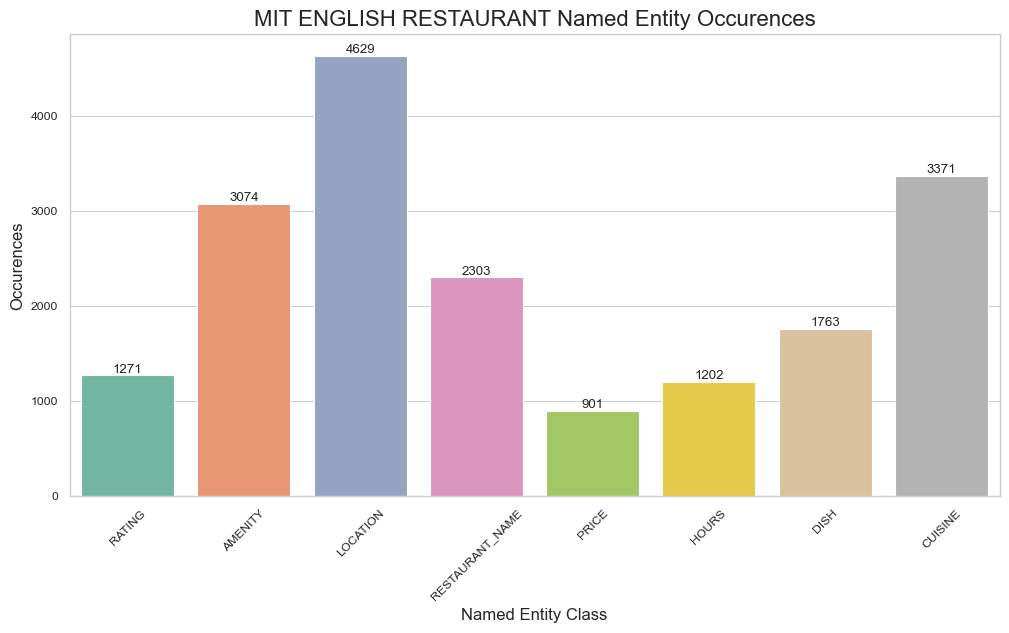

In [12]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='label', y='label_count', data=ne_only_df, hue='label')
plt.title(f"{dataset_name} Named Entity Occurences", fontsize=16)
plt.xlabel("Named Entity Class", fontsize=12)
plt.ylabel("Occurences", fontsize=12)

for i, v in enumerate(ne_only_df['label_count']):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.xticks(rotation=45)

# plt.tight_layout()
save_path = Path(os.getcwd(), "output_figs", f"{dataset_name}_ne_occurences.png")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

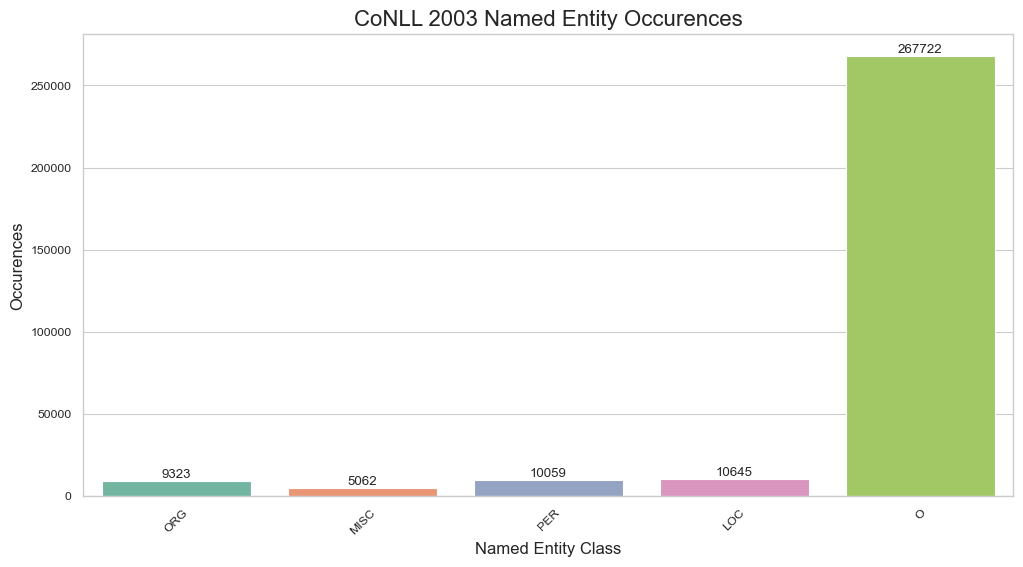

In [30]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(x='label', y='label_count', data=df, hue='label')
plt.title(f"{dataset_name} Named Entity Occurences", fontsize=16)
plt.xlabel("Named Entity Class", fontsize=12)
plt.ylabel("Occurences", fontsize=12)

for i, v in enumerate(df['label_count']):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.xticks(rotation=45)

# plt.tight_layout()
save_path = Path(os.getcwd(), "output_figs", f"{dataset_name}_ne_occurences_full.png")
plt.savefig(save_path, bbox_inches='tight')
plt.show()

In [31]:
def format_output(input_list):
    formatted_output = []
    for item in input_list:
        if item.startswith("("):
            # Remove the outer quotes and parentheses, then join with underscore
            formatted_item = "_".join(item.strip("()").replace("'", "").split(", "))
        else:
            # For items without parentheses, just remove the quotes
            formatted_item = item.replace("'", "")
        
        # Replace all spaces with underscores
        formatted_item = formatted_item.replace(" ", "_")
        
        formatted_output.append(formatted_item)
    return formatted_output

# Example usage
input_list = [
    "('micro avg', 'f1-score')",
    "('micro avg', 'precision')",
    "('micro avg', 'recall')",
    "('macro avg', 'f1-score')",
    "('macro avg', 'precision')",
    "('macro avg', 'recall')",
    'accuracy',
    'loss'
]

result = format_output(input_list)
print(result)

['micro_avg_f1-score', 'micro_avg_precision', 'micro_avg_recall', 'macro_avg_f1-score', 'macro_avg_precision', 'macro_avg_recall', 'accuracy', 'loss']
